# Import required functions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=8, suppress=True)

# Import ML models

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score,mean_absolute_percentage_error

# Load the Data

In [3]:
df0=pd.read_csv("TSLA.csv",index_col=0,parse_dates=True)
df0.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA
2022-06-27,249.366669,252.070007,242.566666,244.919998,89178300,0.0,0.0,239.76
2022-06-28,244.483337,249.970001,232.343338,232.663330,90391200,0.0,0.0,238.89
2022-06-29,230.500000,231.173340,222.273331,228.490005,82897200,0.0,0.0,237.37
2022-06-30,224.509995,229.456665,218.863327,224.473328,94600500,0.0,0.0,235.25
2022-07-01,227.000000,230.229996,222.119995,227.263336,74460300,0.0,0.0,231.56


In [4]:
df=df0[['Close']].copy()

In [5]:
df['logclose']=np.log(df['Close'])
df['logdif']=df['logclose'].diff() # Diff the log close to make the TS stationary

In [6]:
n=12
train=df.iloc[:-n]
test=df.iloc[-n:]

In [7]:
#TS to Superived dataset
# using T past value to predict the next value
series=df['logdif'][1:].values
T=10

X=[]
Y=[]

for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)
X=np.array(X)
Y=np.array(Y)

# Spliting the Train and Test


In [8]:
X_train,y_train=X[:-n],Y[:-n]
X_test,y_test=X[-n:],Y[-n:]

In [9]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

train_idx[:T+1]=False

1. Previous log-passenger count (Day 4): 2.3
2. Predicted difference: 0.15
3. Forecasted log-passenger count (Day 5): 2.3+0.15=2.45

One-step:
**Tommorow's value = Today's value + predicted_diff**



Multistep and Mutlti output:
**Forecast value = last_known_value + cummulative sum of prediction**

example:

**y^​T+3​=yT​+Δy^​T+1​+Δy^​T+2​+Δy^​T+3​**



In [10]:
#de-differencing
df['shiflogclose']=df['logclose'].shift(1)
prev=df['shiflogclose']

In [11]:
def one_step_and_multistep_forecast(model,name):
  model.fit(X_train,y_train)

  # One-Step Forecasting

  print("One-step and Multi forecast of",name)

  df.loc[train_idx,f'{name}_one_step_train']=prev[train_idx]+model.predict(X_train)
  df.loc[test_idx,f'{name}_one_step_test']=prev[test_idx]+model.predict(X_test)


  test_logclose=df.iloc[-n:]['logclose']
  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_one_step_test'])

  print("R2_Training: ", model.score(X_train,y_train))
  print("R2_Test: ", model.score(X_test,y_test))
  print("MAPE-onestep forecast: ",mape)


  # Multi Step Forecasting

  multistep_pred=[]

  last_x=X_test[0]

  while len(multistep_pred)<n:
    p=model.predict(last_x.reshape(1,-1))[0]
    multistep_pred.append(p)

    last_x=np.roll(last_x,-1)
    last_x[-1]=p

  #last-known train value
  last_train=train.iloc[-1]['logclose']

  df.loc[test_idx,f'{name}_multistep']=last_train+np.cumsum(multistep_pred)

  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_multistep'])
  print("MAPE-Multistep forecast: ",mape)

  cols=['logclose',f'{name}_one_step_train',f'{name}_one_step_test',f'{name}_multistep']

  df.iloc[-100:][cols].plot(figsize=(10,5))

One-step and Multi forecast of LR
R2_Training:  0.031751272497459904
R2_Test:  -0.05855491908639965
MAPE-onestep forecast:  0.0037435401224718413
MAPE-Multistep forecast:  0.0033501312033550803


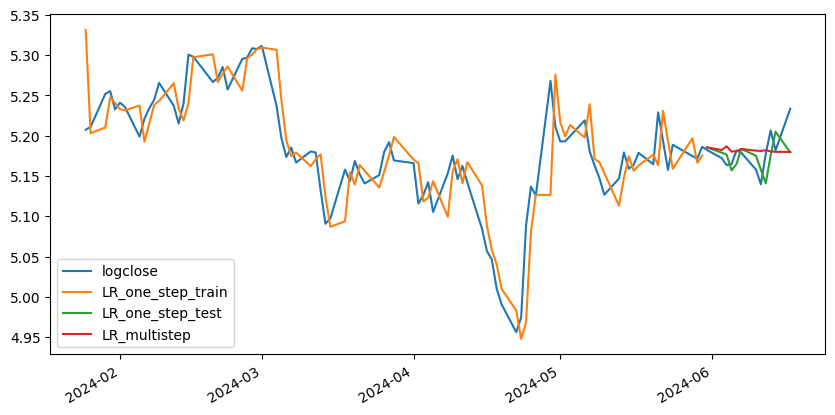

In [12]:
one_step_and_multistep_forecast(LinearRegression(),"LR")

One-step and Multi forecast of SVR
R2_Training:  0.02199610903306426
R2_Test:  -0.2549160710117495
MAPE-onestep forecast:  0.003980935367840198
MAPE-Multistep forecast:  0.009114250115772776


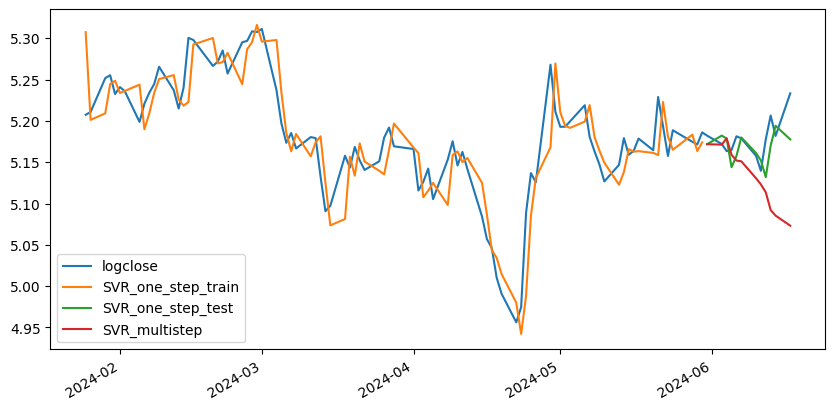

In [13]:
one_step_and_multistep_forecast(SVR(),"SVR")

One-step and Multi forecast of RF
R2_Training:  0.8517504557234398
R2_Test:  -0.4953656083481148
MAPE-onestep forecast:  0.0042857008261816916
MAPE-Multistep forecast:  0.006438509135747193


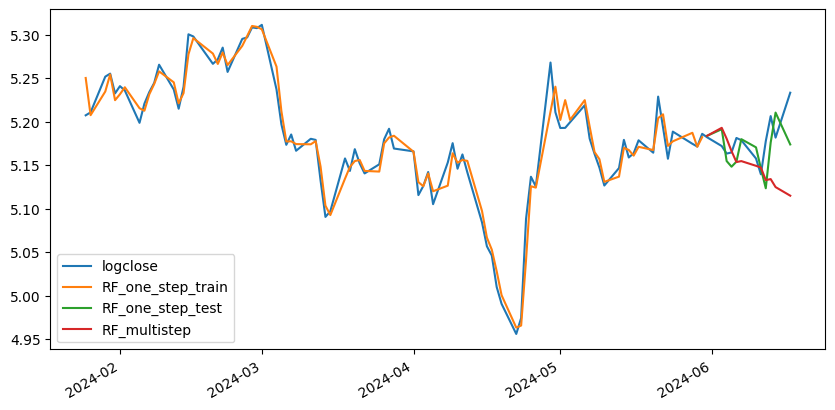

In [14]:
one_step_and_multistep_forecast(RandomForestRegressor(),"RF")

In [15]:
def multi_output_forecast(model,name):

  Tx=T #10
  Ty=n #12

  X=[]
  Y=[]
  for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)

  X=np.array(X)
  Y=np.array(Y)

  X_train_m,y_train_m=X[:-1],Y[:-1]
  X_test_m,y_test_m=X[-1:],Y[-1:]

  model.fit(X_train_m,y_train_m)

  print("R2_Training: ", model.score(X_train_m,y_train_m))
  print("R2_Test: ", r2_score(model.predict(X_test_m).flatten(),y_test_m.flatten()))

  #last-known train value
  last_train=train.iloc[-1]['logclose']

  df.loc[test_idx,f'{name}_multi_out']=last_train+np.cumsum(model.predict(X_test_m).flatten())
  test_logclose=df.iloc[-n:]['logclose']
  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_multi_out'])

  print("MAPE-multi_output_forecast: ",mape)
  cols=['logclose',f'{name}_one_step_train',f'{name}_one_step_test',f'{name}_multistep',f'{name}_multi_out']

  df.iloc[-100:][cols].plot(figsize=(15,6))


R2_Training:  0.020346972701588462
R2_Test:  -62.55935903181812
MAPE-multi_output_forecast:  0.003584944605682461


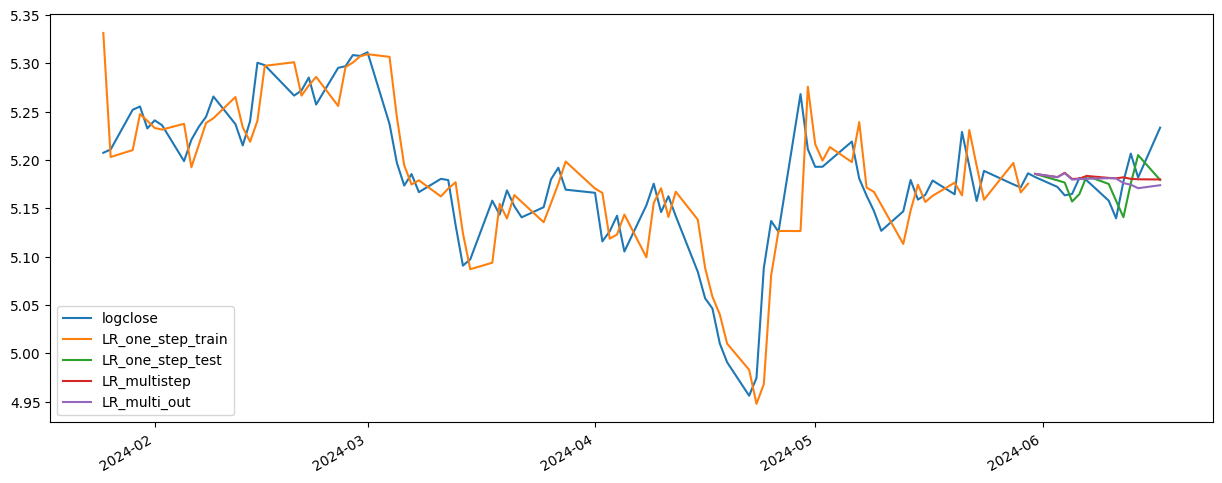

In [16]:
multi_output_forecast(LinearRegression(),"LR")

R2_Training:  0.8500882214678653
R2_Test:  -21.427574738286694
MAPE-multi_output_forecast:  0.0035751620687906305


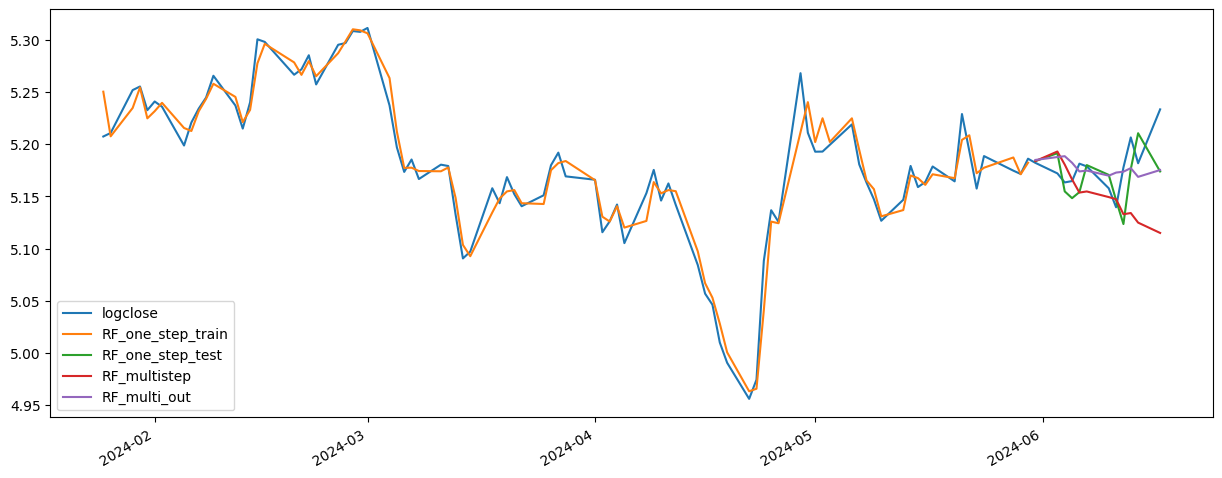

In [17]:
multi_output_forecast(RandomForestRegressor(),"RF")